 <font size="+20">Hidden-Markury</font>

### Hidden-Markov-Model Fitting for FRET-Traces
The Hidden-Markury Notebook is made for the analysis of single-pair FRET-traces of immobilized molecules. It is divided into 10 sections to  load and preprocess the traces, generate and fit the Hidden-Markov-Model (HMM), and evaluate the prediction and fitting results:

0. [Check Requirements and Import Packages](#section_0)
1. [Load and Preprocess Data](#section_1)
2. [Trace Viewer](#section_2)  <font color="gray"><i>(optional)</i></font>
3. [Select Fit Model](#section_3)
4. [Generate Guess and Fit States](#section_4)
5. [Specify HMM and Create Initials](#section_5)
6. [Generate HMM and Fit Data](#section_6)
7. [Plot Prediction Results](#section_7)   <font color="gray"><i>(optional)</i></font>
8. [Lifetime Analysis](#section_8)   <font color="gray"><i>(optional)</i></font>
9. [Vary Fitting (Subset of Traces) and Estimate Error](#section_9)   <font color="gray"><i>(optional)</i></font>

<div class="alert alert-block alert-info">
<b>Tip:</b> You should follow the order of all sections, however, some sections can be skipped (optional).
</div>

***
<a id="section_0"></a>

## 0. Check Requirements and Import Packages

This line checks if all libraries are installed and loads all required packages at the beginning. It returns feedback on which packages to install.

In [1]:
import load_packages
from load_packages import *

All required modules are installed and loaded.

You can go on and play!


<a id="section_1"></a>

## 1. Load and Preprocess Data

When loading the data, you have to adapt the code below according to your data and your file format. There is a built-in `load_trace` function, which can import traces with time-stamps in the first column/row and either the photon data (donor channel/acceptor channel) or FRET efficiencies in one of the other columns/rorws.

Here is an example of an data-format and the required specifications below to load the data properly.

The files are of the form `trace_*.txt` with tab-delimiter in one folder `traces`:
```
%t (s)	Idd (a.u.)	Ida (a.u.)	Iaa (a.u.)	FRET E
0.000	+2.113e+03	+5.966e+03	+6.828e+03	+0.738
0.200	+5.413e+03	+1.918e+03	+6.286e+03	+0.262
0.400	+5.120e+03	+1.690e+03	+7.507e+03	+0.248
0.600	+6.331e+03	+1.856e+03	+8.474e+03	+0.227
0.800	+6.492e+03	+6.661e+02	+9.783e+03	+0.093
```


```python
#files
base_folder = r'examples\sim_190628_100337_level1'
delimiter = '\t'
file_tag = "trace_"
# data columns/rows
DD_col = 1
DA_col = 2
E_col  = 4
```
If you do not have the data of the donor (DD) / acceptor channel (DA) or the FRET efficiency (E), set the corresponding variable `<X>_col = -1`.

If you have a file format, which is not covered by this imput function, you need to modify the import.

<div class="alert alert-block alert-info">
<b>Tip:</b> Check out the example folder first, before modifying the import to your file format.
</div>

In [2]:
# === DATA PARAMETER ===
base_folder = r'examples\sim_190628_100337_level1'
delimiter = '\t'
file_tag = "trace_"

# data columns/rows
DD_col = 1
DA_col = 2
E_col  = 4

scale_photon_counts = 0.001 # scale photon counts, e.g. change from cps to kps
# === DATA PARAMETER ===

# load traces (modify this part if needed)
print("Folder: ", base_folder)
files = oh.list_selected_files(base_folder,tag=file_tag)
print("-- %d traces found --" % len(files))
traces_DD = []
traces_DA = []
traces_E = []
dT = -1
len_tot = 0
for trace_file in files:
    T, DD, DA, E, _ = hh.load_trace(trace_file,1,2,4,delimiter='\t')
    if dT==-1:
        dT = np.mean(np.array(T[1:])-np.array(T[:-1]))
    else:
        pass
    if len(DD)>0:
        traces_DD.append(np.array([T,DD/1000]))
    if len(DA)>0:
        traces_DA.append(np.array([T,DA/1000]))
    if len(E)>0:
        traces_E.append(np.array([T,E]))
    len_tot += len(T)
print("Total length:  "+str(len_tot))
print("Time interval: "+str(dT))

Folder:  examples\sim_190628_100337_level1
-- 50 traces found --
Total length:  51880
Time interval: 0.19999999999999998


At this point, you should have loaded the traces for donor and acceptor channel + efficiencies
The variables `traces_DD` + `traces_DA`, and/or `traces_E` should be a list of np.array pairs of the form

`traces_<X> = [trace1, trace2, trace3, ...]`
 
 with `trace<N>` of the form
 
 `np.array([np.array([t1, t2, t3, ...]),np.array([value1, value2, value3, ...])])`
 
 where `t<N>` are the timestamps of the trace and `value<N>` the corresponding measurement values.

<a id="section_2"></a>

## 2. Trace Viewer

Run cell and click `Next` or `Previous` to iterate through traces.

In [3]:
%matplotlib inline
%load_ext disable_autoscroll
   
# === PLOTTING ===
N_traces = 3   #number of shown traces (at a time)
trace_idx = 0  #start trace

out=widgets.Output()
info = widgets.Output()

# Plot first traces
with out:
    hh.plot_traces(N_traces,trace_idx,traces_DD,traces_DA,traces_E)
with info:
    print("Traces {0:d} - {1:d}".format(trace_idx,trace_idx+N_traces-1))    

# Arrange output (buttons + text + plot)
b_prev=widgets.Button(description='Previous')
b_next=widgets.Button(description='Next')
hbox = widgets.HBox(children=(b_prev,b_next,info))
vbox=widgets.VBox(children=(hbox,out))
display(vbox)

# Define button events (recalculate trace plots)
def click(direction):
    global trace_idx
    if direction=='next':
        trace_idx += N_traces
    elif direction=='back':
        trace_idx -= N_traces
    else:
        raise Exception("Command not defined")
    with out:
        clear_output()
        hh.plot_traces(N_traces,trace_idx,traces_DD,traces_DA,traces_E)
    with info:
        clear_output(wait=True)
        print("Traces {0:d} - {1:d}".format(trace_idx,trace_idx+N_traces-1))
def click_p(b):
    click('back')
def click_n(b):
    click('next')    
b_prev.on_click(click_p)
b_next.on_click(click_n)

<IPython.core.display.Javascript object>

autoscrolling long output is disabled


<a id="section_3"></a>

## 3. Select Fit Model
Select model to analyse your data (number of states and analysis of E-trace or DD/DA-traces). Set `mode = '2D'` for combined donor & acceptor trace analysis or `mode = '1D'` for FRET efficiency trace analysis

Select peak positions of the states by clicking on the peaks in the iterative plot:

<img src="images\2D_FitSelection.png" width="240" align="left">

#### `2D` for combined donor & acceptor trace analysis 
Click on the centers of the populations to give a first estimate for fitting the states. The values are stored in variable `pos`. In this plot for example:

`pos = [[0.81, 6.6, 303], [3.8, 4.0, 228], [7.2, 0.5, 105]]`

<img src="images\1D_FitSelection.png" width="240" align="left">

#### `1D` for FRET efficiency trace analysis
Click on the peaks of the states to give a first estimate for fitting the states. The values are stored in variable `pos`. In this plot for example:

`pos = [[0.11, 2152], [0.55, 4158], [0.85, 5263]]`



For correcting the estimate, click `Clear`.

<div class="alert alert-block alert-warning">
<b>Warning:</b> The switch from inline to notebook backend fails sometimes unpredictable. If no plot appears, run cell again until interactive plot appears.
</div>

<IPython.core.display.Javascript object>


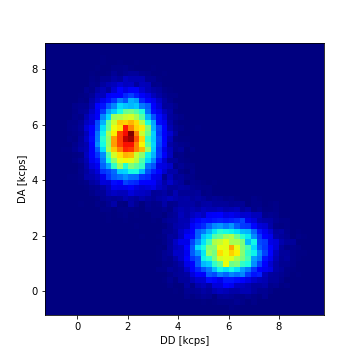

In [4]:
# === SELECT MODE ===

mode = '2D' 

# '2D' for combined donor & acceptor trace analysis
# '1D' for FRET efficiency trace analysis
# === SELECT MODE ===

#Switching from inline to notebook does not always work (see link)
#https://stackoverflow.com/questions/43545050/using-matplotlib-notebook-after-matplotlib-inline-in-jupyter-notebook-doesnt
for i in range(5):
    %matplotlib notebook
    time.sleep(0.2)

#Validate selection
if mode == '2D':
    assert len(traces_DD)>0 and len(traces_DA)==len(traces_DD) , "Mode does not work with type of imported data - no photon count trace for donor and acceptor loaded"
elif mode == '1D':
    assert len(traces_E)>0 , "Mode does not work with type of imported data - no FRET efficiency trace loaded"
else:
    assert -1>0 , "Mode '" + mode + "' not defined"

# === PLOTTING ===
#%load_ext disable_autoscroll
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
if mode=='2D':
    scatter_DD = traces_DD[0][1]
    scatter_DA = traces_DA[0][1]
    for trace_DD, trace_DA in zip(traces_DD[1:],traces_DA[1:]):
        scatter_DD = np.append(scatter_DD, trace_DD[1])
        scatter_DA = np.append(scatter_DA, trace_DA[1])
    hist_data, xbins, ybins = np.histogram2d(scatter_DD, scatter_DA, bins=50)
    DD_min = min([min(t[:,1]) for t in traces_DD])
    DD_max = max([max(t[:,1]) for t in traces_DD])
    DA_min = min([min(t[:,1]) for t in traces_DA])
    DA_max = max([max(t[:,1]) for t in traces_DA])
    
    ax.hist2d(scatter_DD, scatter_DA, bins=(50, 50), cmap=plt.cm.jet)
    try:
        idx = np.log10(scale_photon_counts)/3
        if idx.is_integer():
            cts = "[" + ["","m","mu","M","k"][int(idx)] + "cps]"
        else:
            cts = "[a.u.]"
    except:
        cts = "[a.u.]"
    ax.set_xlabel("DD "+cts)
    ax.set_ylabel("DA "+cts)
else:
    long_trace_E = traces_E[0][1]
    for trace_E  in traces_E[1:]:
        long_trace_E = np.append(long_trace_E, trace_E[1])
    bins=np.linspace(-0.2,1.2,num=50)
    #bins = [np.linspace(s_T, e_T[i], num=int(np.round((e_T[i]-s_T)/dTbin[i])+1)) for i in range(nbr_states)]
    print(min(long_trace_E))
    print(max(long_trace_E))
    ax.hist(long_trace_E, bins=bins)
    hist_data, bins_h1D =np.histogram(long_trace_E, bins=bins)
    max_hist = max(hist_data)
    ax.set_xlabel("E")
    ax.set_ylabel("Events")
    ax.set_xlim(xmin=-0.2, xmax = 1.2)
#plt.savefig('test.png', dpi=300)
   
pos = []
def onclick(event):
    if mode=='2D':
        x_pos = np.abs(xbins - event.xdata).argmin()
        y_pos = np.abs(ybins - event.ydata).argmin()
        z = hist_data[x_pos,y_pos]
        pos.append([event.xdata,event.ydata,z])
    else:
        pos.append([event.xdata,event.ydata])
    with pos_out:
        clear_output(wait=True)
        print("Selected positions: ",pos)   
cid = fig.canvas.mpl_connect('button_press_event', onclick)
out=widgets.Output()
pos_out = widgets.Output()
button=widgets.Button(description='Clear')
vbox=widgets.VBox(children=(out,pos_out,button))
display(vbox)

with pos_out:
    print("Selected positions: ",pos)
    
# button to clear selection
def click(b):
    global pos
    pos = []
    with pos_out:
        clear_output(wait=True)
        print("Selected positions: ",pos)
        #text.set_text("")
button.on_click(click)

<a id="section_4"></a>

## 4. Generate Guess and Fit States
Funchtion `guess` generates a guess for fitting based on the selection of the previous cell. You can override the variable `guess`, if the fit in the following cell fails.

For `2D`-mode, `guess`is of the form
```python
guess = [A1, mu_DD1, sigma_DD1, mu_DA1, sigma_DA1, A2, mu_DD2, sigma_DD2, mu_DA2, sigma_DA2, ...]
```
For `1D`-mode, `guess`is of the form
```python
guess = [A1, mu_E1, sigma_E1, A2, mu_E2, sigma_E2, ...]
```

In [5]:
guess = []
if mode=='2D':
    hist_data, xbins, ybins = np.histogram2d(scatter_DD, scatter_DA, bins=50)
    hist_data_ravel = hist_data.T.ravel()
    x_fit, y_fit = np.meshgrid(xbins[:-1]+(xbins[1]-xbins[0])/2, ybins[:-1]+(ybins[1]-ybins[0])/2)
    for p in pos:
        guess += [p[2], p[0], (xbins[-1]-xbins[0])/8., p[1], (ybins[-1]-ybins[0])/10.]
    GAUSS_N = 5
else:
    bins=np.linspace(-0.2,1.2,num=50)
    hist_data, bins_h1D =np.histogram(long_trace_E, bins=bins)
    x_fit = np.linspace(bins_h1D[0]+(bins_h1D[1]-bins_h1D[0])/2,bins_h1D[-1]-(bins_h1D[1]-bins_h1D[0])/2,num=len(bins)-1)
    for p in pos:
        guess += [p[1], p[0], 0.1]
    GAUSS_N = 3
print("guess = "+str(guess))
hh.print_gaussians(guess, mode)


guess = [230.0, 5.906161406486266, 1.38425, 1.6477265480159398, 0.9793499999999999, 366.0, 1.9766775355185233, 1.38425, 5.575215510488347, 0.9793499999999999]
---------------------------------------
Gaussian parameter
Gaussian 0: A0:230, mu_DD0:5.91, sigma_DD0:1.38, mu_DA0:1.65, sigma_DA0:0.98
Gaussian 1: A1:366, mu_DD1:1.98, sigma_DD1:1.38, mu_DA1:5.58, sigma_DA1:0.98
---------------------------------------


popt_init =  [249.28934288   5.9795086    0.89527546   1.50726389   0.64450693
 345.03804559   2.01194175   0.71853004   5.48545005   0.8528452 ]
---------------------------------------
Gaussian parameter
Gaussian 0: A0:249, mu_DD0:5.98, sigma_DD0:0.90, mu_DA0:1.51, sigma_DA0:0.64
Gaussian 1: A1:345, mu_DD1:2.01, sigma_DD1:0.72, mu_DA1:5.49, sigma_DA1:0.85
---------------------------------------


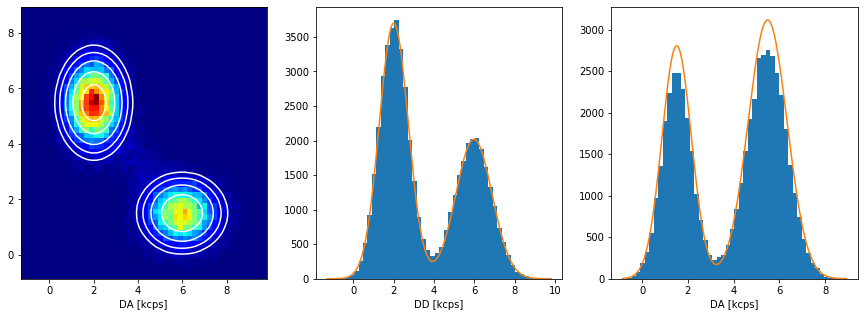

In [6]:
%matplotlib inline

# === FITTING ===
if mode=='2D':
    popt_init, pcov = curve_fit(hh.gauss_2D, (x_fit.ravel(),y_fit.ravel()), hist_data_ravel, p0=guess)
else:
    popt_init, pcov = curve_fit(hh.gauss_1D, x_fit, hist_data, p0=guess)
print("popt_init = ",str(popt_init))
hh.print_gaussians(popt_init,mode)

# === PLOTTING ===
if mode=='2D':
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].hist2d(scatter_DD, scatter_DA, bins=(50, 50), cmap=plt.cm.jet)

    data_fitted = hh.gauss_2D((x_fit.ravel(), y_fit.ravel()), *popt_init)
    max_hist = np.max(hist_data)
    axes[0].contour(xbins[:-1]+(xbins[1]-xbins[0])/2,ybins[:-1]+(ybins[1]-ybins[0])/2, data_fitted.reshape(50, 50), levels=np.array([0.05,0.1,0.2,0.4,0.7])*max_hist, colors='w')

    x_ax = np.linspace(xbins[0], xbins[-1], num=500)
    y_ax = np.linspace(ybins[0], ybins[-1], num=500)
    para_x = list(np.ravel([[sigma2*A, mu, sigma] for A,mu,sigma,mu2,sigma2 in hh.grouped_list(popt_init, GAUSS_N)]))
    x_hist = hh.gauss_1D(x_ax,*para_x)
    para_y = list(np.ravel([[sigma*A, mu2, sigma2] for A,mu,sigma,mu2,sigma2 in hh.grouped_list(popt_init, GAUSS_N)]))
    y_hist = hh.gauss_1D(y_ax,*para_y)
    axes[0].set_xlabel("DD [kcps]")
    axes[0].set_xlabel("DA [kcps]")
    axes[1].hist(scatter_DD, bins=50)
    axes[1].plot(x_ax, 4*np.pi*x_hist)
    axes[1].set_xlabel("DD [kcps]")
    #axes[1].set_xlabel("DA [kcps]")
    axes[2].hist(scatter_DA, bins=50)
    axes[2].plot(y_ax, 4*np.pi*y_hist)
    axes[2].set_xlabel("DA [kcps]")
    #axes[2].set_xlabel("DA [kcps]")
else:
    fig, axes = plt.subplots(1, 1, figsize=(5,5))
    bins=np.linspace(-0.2,1.2,num=50)
    axes.hist(long_trace_E, bins=bins)
    E_fit = hh.gauss_1D(np.linspace(-0.2,1.2,1000),*popt_init)
    axes.plot(np.linspace(-0.2,1.2,1000),E_fit)
    axes.set_xlabel("E")
    axes.set_ylabel("Events")
    axes.set_xlim(xmin=-0.2, xmax = 1.2)
plt.show()

<a id="section_5"></a>

## 5. Specify Hidden-Markov-Model (HMM) and Create Initials
Here, you have to select some general parameter of the HMM, before initializing the model and fit the trace data:
1. Set `degenerated_states = True` if you expect degenerated states 
2. If there are degenerated states, specify degeneration for each state: e.g. `degeneration = [2,1,1]` means that the first state is degenerated, the others not
3. If ther is no degenerated state, specify if you want to optimize the states durch the HMM-fitting or not (for degenerated states, the states have to be fixed)

The function `generate_hmm_initials` pre-calculates initial values for the states (mean & covariance), the transition matrix and the start probability of each state. You can override the values, if the fit fails or you have a better guess.

In [7]:
# === SPECIFY HMM ===
degenerated_states = False
degeneration = [1,2,1]
fix_states = True #for degenerated states, states are always fixed (assignment is ignored)
# == SPECIFY HMM ===

if degenerated_states: 
    assert len(degeneration) < np.sum(degeneration), "Degenerated states does not fit total number of states"
    nbr_states = np.sum(degeneration)
    fix_states = True
else:
    nbr_states = int(len(popt_init)/GAUSS_N)
    degeneration = [1 for i in range(nbr_states)]
                
means, covs, trans_mat, starts = hh.generate_hmm_initials(popt_init, degeneration, mode)

means, covs, trans_mat, starts

([[5.97950859561722, 1.5072638852353581],
  [2.0119417461489726, 5.48545004926164]],
 [[[0.8015181500957903, 0], [0, 0.4153891773982669]],
  [[0.5162854244369703, 0], [0, 0.7273449390142117]]],
 array([[0.96, 0.04],
        [0.04, 0.96]]),
 array([0.40487116, 0.59512884]))

<div class="alert alert-block alert-info">
<b>Tip:</b> For complex systemes (e.g. many states), you might want to specify the initial transition matrix manually and set some transitions zero.
</div>

<div class="alert alert-block alert-warning">
<b>Info:</b> Adapt the matrix dimensions/entries and run this cell only if the initial guess does not converge to a adequate solution!.
</div>

In [29]:
# OVERRIDE INITIAL GUESSES AND SET "MANUEL=True" ONLY IF NEEDED
MANUAL = False
If MANUAL:
    trans_mat = np.array([[0.96, 0.02,0.01,0.01],
                          [0.05,0.7,0.24,0.01],
                          [0.01,0.25,0.73,0.01],
                          [0.02,0.01,0.01,0.96]])

<a id="section_6"></a>

## 6. Generate HMM and Fit Data
This cell contains the important steps:
1. The HMM is created as `model` and initialised with the settings from above
2. The data are prepared for fitting (one long trace, length specification of individual traces)
3. The model is fit
4. The states are predicted based on the fitted model
5. The prediction results are added to the traces

In [8]:
"""
Several different starting points are recommended (gradient based approach)

"""
# === CREATE MODEL ===
if fix_states or degenerated_states:
    model = hmm.GaussianHMM(n_components=nbr_states, covariance_type="full", init_params="",params="ts", n_iter=100)
else:
    model = hmm.GaussianHMM(n_components=nbr_states, covariance_type="full", init_params="",params="mcts", n_iter=100)
model.startprob_ = np.array(starts)
model.transmat_ = np.array(trans_mat)
model.means_ = np.array(means)
model.covars_ = np.array(covs)

# === FIT MODEL ===
#prepare data
if mode=='2D':
    traces_y = [np.array([trace_DD[1], trace_DA[1]]).T for trace_DD, trace_DA in zip(traces_DD,traces_DA)]
else:
     traces_y = [np.array([trace_E[1]]).T for trace_E in traces_E]
traces_all = np.concatenate(traces_y)
lengths = [len(t) for t in traces_y]

#fit model and calculate rates from transition matrix
fit_result = model.fit(traces_all, lengths)
rates = np.array([(1-model.transmat_[i,i])/dT for i in range(len(model.transmat_))])

#predict values
predictions = model.predict(traces_all, lengths)

#append fitted values to traces
len_cum = 0
traces_DD_fit = []
traces_DA_fit = []
traces_E_fit = []
prediction_traces = []
for idx, length in enumerate(lengths):
    prediction = predictions[len_cum:len_cum+length]
    prediction_traces.append(np.array(prediction))
    if mode=='1D':
        E_fit = np.array([means[s][0] for s in  prediction])
        traces_E_fit.append(np.array([traces_E[idx][0],traces_E[idx][1],E_fit]))
    if mode=='2D':
        DD_fit = np.array([means[s][0] for s in  prediction])
        DA_fit = np.array([means[s][1] for s in  prediction])
        traces_DD_fit.append(np.array([traces_DD[idx][0],traces_DD[idx][1],DD_fit]))
        traces_DA_fit.append(np.array([traces_DA[idx][0],traces_DA[idx][1],DA_fit]))
        E_fit = np.divide(DA_fit,(DA_fit+DD_fit))
        if len(traces_E)>0:
            traces_E_fit.append(np.array([traces_E[idx][0],traces_E[idx][1],E_fit]))        
    len_cum += length
    
model.monitor_.converged, fit_result, model.monitor_, model.means_, model.transmat_, rates

(True,
 GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
             covars_weight=1, init_params='', means_prior=0, means_weight=0,
             min_covar=0.001, n_components=2, n_iter=100, params='ts',
             random_state=None, startprob_prior=1.0, tol=0.01,
             transmat_prior=1.0, verbose=False),
 ConvergenceMonitor(
     history=[-130603.1947760365, -130603.19468042969],
     iter=3,
     n_iter=100,
     tol=0.01,
     verbose=False,
 ),
 array([[5.9795086 , 1.50726389],
        [2.01194175, 5.48545005]]),
 array([[0.9535845 , 0.0464155 ],
        [0.03136011, 0.96863989]]),
 array([0.23207748, 0.15680055]))

<a id="section_7"></a>

## 7. Plot Prediction Results

In [9]:
%matplotlib inline
%load_ext disable_autoscroll
reload(hh)
# === PLOTTING ===
N_traces = 3   #number of shown traces (at a time)
trace_idx = 0  #start trace

out=widgets.Output()
info = widgets.Output()

# Plot first traces
with out:
    hh.plot_traces(N_traces,start=trace_idx, traces_DD=traces_DD_fit, traces_DA=traces_DA_fit,traces_E=traces_E_fit,prediction=True)
with info:
    print("Traces {0:d} - {1:d}".format(trace_idx,trace_idx+N_traces-1))    

# Arrange output (buttons + text + plot)
b_prev=widgets.Button(description='Previous')
b_next=widgets.Button(description='Next')
hbox = widgets.HBox(children=(b_prev,b_next,info))
vbox=widgets.VBox(children=(hbox,out))
display(vbox)

# Define button events (recalculate trace plots)
def click(direction):
    global trace_idx
    if direction=='next':
        trace_idx += N_traces
    elif direction=='back':
        trace_idx -= N_traces
    else:
        raise Exception("Command not defined")
    with out:
        clear_output()
        hh.plot_traces(N_traces,start=trace_idx, traces_DD=traces_DD_fit, traces_DA=traces_DA_fit,traces_E=traces_E_fit,prediction=True)
    with info:
        clear_output(wait=True)
        print("Traces {0:d} - {1:d}".format(trace_idx,trace_idx+N_traces-1))
def click_p(b):
    click('back')
def click_n(b):
    click('next')    
b_prev.on_click(click_p)
b_next.on_click(click_n)

The disable_autoscroll extension is already loaded. To reload it, use:
  %reload_ext disable_autoscroll


<a id="section_8"></a>

## 8. Lifetime Analysis

Dwell times are extracted from prediction results, where the last state is discarded due to bleaching. Bin widths are automatically generated based on averaged dwell times. Exponential fit is performed with 4 slightly different bin sizes and averaged.

-- bin widths (states 1-2) --
[3.3578231292517002, 4.894818652849741]
-- bin widths (states 1-2) --
[2.68625850340136, 3.915854922279793]
-- bin widths (states 1-2) --
[2.01469387755102, 2.9368911917098446]
-- bin widths (states 1-2) --
[1.611755102040816, 2.3495129533678756]


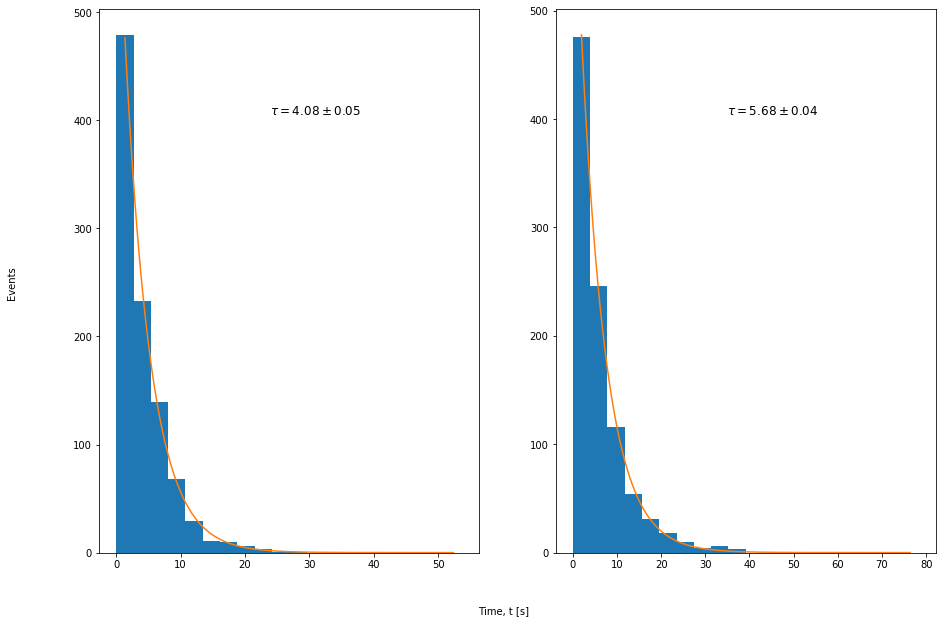

In [11]:
#estract dwelltimes from traces
lifetime_traces = [hh.split_trace(pred, nbr_max=(nbr_states-1),skip_last=True) for pred in prediction_traces]
lifetimes_all = hh.cumulate_lifetimes(lifetime_traces)
lifetime_states = [np.array(l)*dT for l in lifetimes_all]

np.seterr(over='ignore')
fits_all = []
for rnd, bin_div in enumerate([1.2,1.5,2,2.5]): #do lifetime analysis for different bin sizes
    #define individual bin-width and range for diffent states
    dTbin = []
    s_T = 0
    e_T = []
    for i in range(nbr_states):
        mean = np.mean(lifetime_states[i])
        dTbin.append(mean/bin_div)
        e_T.append(20*dTbin[i])
    print("-- bin widths (states {0:d}-{1:d}) --".format(1,nbr_states))
    print(dTbin)
    xs = [np.linspace(s_T+dTbin[i]/2, e_T[i]-dTbin[i]/2, num=int(np.round((e_T[i]-s_T)/dTbin[i]))) for i in range(nbr_states)]
    xs_fit =[np.linspace(s_T+dTbin[i]/2, e_T[i]-dTbin[i]/2, num=1000) for i in range(nbr_states)]
    bins = [np.linspace(s_T, e_T[i], num=int(np.round((e_T[i]-s_T)/dTbin[i])+1)) for i in range(nbr_states)]

    #fit exponential and plot
    hist_T = []
    fits = []
    fit_res = []
    if rnd==1:
        fig, axes = plt.subplots(1,nbr_states,figsize=(15,10))
        fig.text(0.5, 0.04, 'Time, t [s]', ha='center')
        fig.text(0.04, 0.5, 'Events', va='center', rotation='vertical')
    for i in range(nbr_states):
        y,_ = np.histogram(lifetime_states[i], bins=bins[i])
        hist_T.append(y)
        guess=[max(y),0.5]
        popt, pcov = curve_fit(hh.func_exp, xs[i], y, p0=guess)
        fit = hh.func_exp(xs_fit[i], *popt)
        fits.append(fit)
        fit_res.append(popt)
        if rnd==1:
            axes[i].hist(lifetime_states[i], bins=bins[i])
            axes[i].plot(xs_fit[i], fit)
    fits_all.append(fit_res)

for i, taus in enumerate(np.array(fits_all).T[1]):    
    axes[i].annotate(r'$\tau={0:.2f} \pm {1:.2f}$'.format(np.mean(1/taus),np.std(1/taus)), xy=(0.45, 0.8), xycoords='axes fraction', fontsize=12,
                horizontalalignment='left', verticalalignment='bottom')

<a id="section_9"></a>

## 9. Vary Fitting (Subset of Traces) and Estimate Error
The fit quality of the model is estimated by variation of the imput data. The variable `rounds = 20` sets the number of variations and `selection = 0.6` specifies the size of the subset relative to the total number of traces.

Note that multiple occurence of one trace in the subset is possible (sampling with replacement)

In [13]:
# === VARIATION PARAMETER ===
#prepare shuffle
rounds = 20      # number of variation rounds
selection = 0.6  # ratio of selection size compared to total number of traces
# === VARIATION PARAMETER ===

# === CREATE MODEL ===
if fix_states or degenerated_states:
    model = hmm.GaussianHMM(n_components=nbr_states, covariance_type="full", init_params="",params="ts", n_iter=100)
else:
    model = hmm.GaussianHMM(n_components=nbr_states, covariance_type="full", init_params="",params="mcts", n_iter=100)
model.startprob_ = np.array(starts)
model.transmat_ = np.array(trans_mat)
model.means_ = np.array(means)
model.covars_ = np.array(covs)

# === FIT MODEL ===
tag_DA_E = "E" if mode=="1D" else "DA"
tag_fix = "fix" if fix_states else "free"
tag_sel = str(selection)
timestr = time.strftime("%Y-%m-%d-%H.%M.%S")
folder_name = "model_fit_"  + tag_DA_E + "_" + tag_fix + "_" + tag_sel + "_" + timestr
folder_model_fit = os.path.join(base_folder,folder_name)
if not os.path.exists(folder_model_fit):
    os.makedirs(folder_model_fit)

for rnd in range(rounds):

    randTraceIdx = np.random.randint(len(traces_DD), size=int(selection*len(traces_DD)))
    randTraces_DD = [traces_DD[i] for i in randTraceIdx]
    randTraces_DA = [traces_DA[i] for i in randTraceIdx]


    #prepare data
    if mode=='2D':
        traces_y = [np.array([trace_DD[1], trace_DA[1]]).T for trace_DD, trace_DA in zip(randTraces_DD,randTraces_DA)]
    else:
         traces_y = [np.array([trace_E[1]]).T for trace_E in traces_E]
    traces_all = np.concatenate(traces_y)
    lengths = [len(t) for t in traces_y]

    #fit model and calculate rates from transition matrix
    fit_result = model.fit(traces_all, lengths)
    

    name_model = "model_" + tag_DA_E + "_" + tag_fix + "_" + tag_sel + "_" + str(rnd) + ".txt"
    path_model = os.path.join(folder_model_fit,name_model)
    hh.save_model(model,path_model)
    name_tm = "transition_matrix_" + tag_DA_E + "_" + tag_fix + "_" + tag_sel + "_" + str(rnd) + ".tsv"
    path_tm = os.path.join(folder_model_fit,name_tm)
    np.savetxt(path_tm, model.transmat_)

Calculate Mean and Standard-Deviation of fit runs

In [14]:
# load matrices
print("Folder: ", folder_model_fit)
files = oh.list_selected_files(folder_model_fit,tag="transition_matrix")
tms = []
for file in files:
    tms.append(np.loadtxt(file)/dT)
tms = np.array(tms)

tm_mean = np.mean(tms,axis=0)
path = os.path.join(folder_model_fit,"transition_matix_mean.tsv")
np.savetxt(path, tm_mean)
print("-- mean transition matrix --")
print(tm_mean)
tm_stdDev = np.std(tms,axis=0)
path = os.path.join(folder_model_fit,"transition_matix_stdDev.tsv")
np.savetxt(path, tm_stdDev)
print("-- standard deviation transition matrix --")
print(tm_stdDev)

Folder:  G:\Programming\Jupyter\HMM\Hidden-Marcury\examples\sim_190628_100337_level1\model_fit_DA_fix_0.6_2019-11-27-16.27.20
-- mean transition matrix --
[[4.76866617 0.23133383]
 [0.15654305 4.84345695]]
-- standard deviation transition matrix --
[[0.0070812  0.0070812 ]
 [0.00577146 0.00577146]]
